In [1]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
import os
import pdfplumber
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from gensim.corpora import Dictionary
from gensim.models import HdpModel



# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdlacey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cdlacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample_385'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  385


In [3]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample_385'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 30365
Mean page count per file: 79.07552083333333
Median page count per file: 80.0


In [4]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # Remove specific words or letters which are not useful
    additional_stopwords = {
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"}
    tokens = [token for token in tokens if token not in additional_stopwords]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Directory path containing PDF files
pdf_directory = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample_385'

# List all PDF files in the directory
pdf_files = [os.path.join(pdf_directory, file) for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

texts = []

# Loop through each PDF file and extract text
for pdf_file in pdf_files:
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        texts.append(text)

# Preprocess text
preprocessed_texts = [preprocess_text(text) for text in texts]

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


In [5]:
#spliting data for cross validation
from sklearn.model_selection import train_test_split

train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

In [6]:
# Train the HDP model
hdp_model = HdpModel(train_corpus, id2word=dictionary)

In [7]:
#First evaluation of HDP model and number of topics identified per document)
rows = []

# Iterate through each document in the corpus
for i, doc in enumerate(corpus):
    doc_topics = hdp_model[doc]
    # Extract topic numbers and their probabilities
    topic_numbers = [topic[0] for topic in doc_topics]
    topic_probs = [topic[1] for topic in doc_topics]
    # Append the document's topics to the rows list
    rows.append([i, topic_numbers, topic_probs])

# Create a DataFrame from the list of rows
doc_topics_df = pd.DataFrame(rows, columns=['Document_Index', 'Topic_Numbers', 'Topic_Probabilities'])

# Display the DataFrame
doc_topics_df.head(10)

,Document_Index,Topic_Numbers,Topic_Probabilities
0,0,"[0, 1, 2, 3, 4, 7, 10, 11, 13, 20, 23, 25, 28,...","[0.10017104054016683, 0.1805707105216867, 0.06..."
1,1,[5],[0.9999112944541129]
2,2,"[0, 1, 11, 16]","[0.8172776543355172, 0.020018503679442905, 0.1..."
3,3,"[1, 3, 4]","[0.18695272051488102, 0.6892149422181916, 0.12..."
4,4,[2],[0.9999233867469903]
5,5,"[1, 3, 4]","[0.417312866880658, 0.3919679456655269, 0.1902..."
6,6,"[1, 3, 19]","[0.21960622617773107, 0.03429964829885137, 0.7..."
7,7,"[0, 3, 14, 18, 26]","[0.9013955265537144, 0.013980340032911985, 0.0..."
8,8,"[0, 6, 11, 20]","[0.6605232470947535, 0.04294565521504616, 0.25..."
9,9,"[2, 3, 5, 9, 12, 15, 30]","[0.016686183015924942, 0.023801653726668662, 0..."


In [8]:
# To find an approximate number of total topics identified within the HDP model, I found it easiest to train an
#LDA model on the HDP model. 
# Here we'll train an LDA model using the HDP model as a training mechanism
lda_model_t = hdp_model.suggested_lda_model()

# Get the topic distributions for each document
doc_topics = [lda_model_t.get_document_topics(doc) for doc in corpus]

# Count the number of unique topics
unique_topics = set()
for doc_topics in doc_topics:
    unique_topics.update([topic[0] for topic in doc_topics])

num_topics_identified = len(unique_topics)
print(f"Number of topics identified by HDP model: {num_topics_identified}")


Number of topics identified by HDP model: 36


In [9]:
#From the Literature Review, the ideal topics for LDA was found to be 7. 
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(train_corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=10, passes=10)

In [11]:
#Evaluating LDA topic coherance values. 
from gensim.models import CoherenceModel

# Calculate coherence values for each topic
coherence_values = {}
for topic_num in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_num)
    topic_words = [term for term, _ in topic_terms]
    coherence_model = CoherenceModel(topics=[topic_words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.3465939617099905
1	0.43092406930711097
2	0.3791374482250306
3	0.831290134782115
4	0.831290134782115
5	0.831290134782115
6	0.831290134782115


In [12]:
# Finding the overall LDA model coherance value
topics = lda_model.show_topics(num_topics=-1, formatted=False)

# Calculate coherence values for each topic
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print("Coherence Score for LDA model:", coherence_lda)

Coherence Score for LDA model: 0.7021601704922079


In [13]:
#Evaluating HDP topic coherance values, which were found to have a range below as well as above the LDA model
from gensim.models import CoherenceModel

hdp_topics = hdp_model.show_topics(num_topics=35, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.30577530491167954
1	0.3704427655160743
2	0.3071756104752924
3	0.37874539741416224
4	0.3608024917508687
5	0.2739742704325708
6	0.30596453345919983
7	0.3189199251404705
8	0.3035619645996537
9	0.3037049621202236
10	0.2944990698363773
11	0.35423923291756776
12	0.2910631338639801
13	0.30422166822791985
14	0.33815653852715855
15	0.26669686555606337
16	0.29199334772783136
17	0.28967371032797445
18	0.44004503836624254
19	0.30628265551364053
20	0.24662555369761957
21	0.31301332934437986
22	0.34637308299715114
23	0.4084494330780527
24	0.2990663375879524
25	0.3364569411073398
26	0.4324984520773717
27	0.3496508542985618
28	0.4222126195528789
29	0.3094334849829136
30	0.28432890091207547
31	0.2908556155707057
32	0.2718517864207144
33	0.2961464155335241
34	0.3116577889886484


In [14]:
# Finding the overall coherhance value for HDP model
hdp_topics = hdp_model.show_topics(num_topics=35, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Compute the average coherence value
avg_coherence_value = sum(coherence_values.values()) / len(coherence_values)

print("Overall Coherence Value for HDP model:", avg_coherence_value)

Overall Coherence Value for HDP model: 0.32355883093813836


In [15]:
#Generate df with dominant topics, the topic contribution and topic keywords for LDA model
import pandas as pd

def format_topics(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df


df_topic_keywords = format_topics(ldamodel=lda_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2,0.7754,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
1,2,0.6111,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
2,2,0.7158,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
3,1,0.9530,"need, work, want, support, get, make, common, ...","[parliament, session, common, debat, offici, r..."
4,2,0.9482,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
5,1,0.8933,"need, work, want, support, get, make, common, ...","[parliament, session, common, debat, offici, r..."
6,2,0.9467,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
7,2,0.8866,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
8,2,0.8737,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."
9,2,0.6148,"commonsdeb, work, english, order, translat, su...","[common, debat, volum, number, session, parlia..."


In [16]:
#Generate df of represtative text for dominant topics for LDA model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format DF
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1,0.9990,"need, work, want, support, get, make, common, like, know, question","[parliament, session, common, debat, offici, report, hansard, volum, wednesday, june, honour, an..."
1,2,0.9988,"commonsdeb, work, english, order, translat, support, like, nation, make, new","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, march, h..."


In [17]:
#Generate df with dominant topics, the topic contribution and topic keywords for HDP model
import pandas as pd

def topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, topics in enumerate(ldamodel[corpus]):
        # Sort topics by contribution
        topics = sorted(topics, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == 0:  # Dominant topic
                topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df

df_topic_keywords = topics_sentences(ldamodel=hdp_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,1,0.1806,"need, work, want, make, support, like, know, get, right, common, import, say, question, us, comm...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, januari, ho..."
1,5,0.9999,"ontario, countri, support, need, commonsdeb, work, qubec, right, english, nation, make, like, im...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
2,0,0.8173,"work, need, support, make, commonsdeb, like, order, want, english, know, right, nation, countri,...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, june, honou..."
3,3,0.6892,"work, need, right, support, want, make, get, like, common, know, import, us, question, mani, cou...","[parliament, session, common, debat, offici, report, hansard, volum, friday, june, honour, antho..."
4,2,0.9999,"commonsdeb, work, support, english, need, countri, translat, like, make, order, want, nation, ne...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, may, hono..."
5,1,0.4173,"need, work, want, make, support, like, know, get, right, common, import, say, question, us, comm...","[parliament, session, common, debat, offici, report, hansard, volum, tuesday, march, honour, ant..."
6,19,0.7408,"account, work, order, commonsdeb, parliament, want, like, polit, make, parti, feder, english, of...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
7,0,0.9014,"work, need, support, make, commonsdeb, like, order, want, english, know, right, nation, countri,...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
8,0,0.6605,"work, need, support, make, commonsdeb, like, order, want, english, know, right, nation, countri,...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, april, hon..."
9,5,0.6264,"ontario, countri, support, need, commonsdeb, work, qubec, right, english, nation, make, like, im...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."


In [18]:
#Generate df of represtative text for dominant topics for HDP model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1.0000,"work, need, support, make, commonsdeb, like, order, want, english, know, right, nation, countri,...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, novemb, hon..."
1,1,0.9999,"need, work, want, make, support, like, know, get, right, common, import, say, question, us, comm...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
2,2,1.0000,"commonsdeb, work, support, english, need, countri, translat, like, make, order, want, nation, ne...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, januari, ho..."
3,3,0.9999,"work, need, right, support, want, make, get, like, common, know, import, us, question, mani, cou...","[parliament, session, common, debat, offici, report, hansard, volum, wednesday, april, honour, a..."
4,4,0.9999,"right, need, work, want, question, support, like, common, know, make, order, us, countri, say, i...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, april, part..."
5,5,0.9999,"ontario, countri, support, need, commonsdeb, work, qubec, right, english, nation, make, like, im...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
6,6,0.9999,"work, right, commonsdeb, english, support, translat, order, like, make, countri, want, import, w...","[common, debat, volum, number, session, parliament, offici, report, hansard, wednesday, februari..."
7,7,0.9556,"commonsdeb, like, want, work, english, cbc, talk, support, import, commun, make, translat, know,...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, may, hono..."
8,8,0.9528,"work, commun, support, commonsdeb, tax, post, make, english, servic, famili, like, want, mani, n...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, januari, h..."
9,9,0.9999,"ontario, quebec, nation, english, countri, translat, commonsdeb, qubec, work, order, like, say, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, june, honou..."


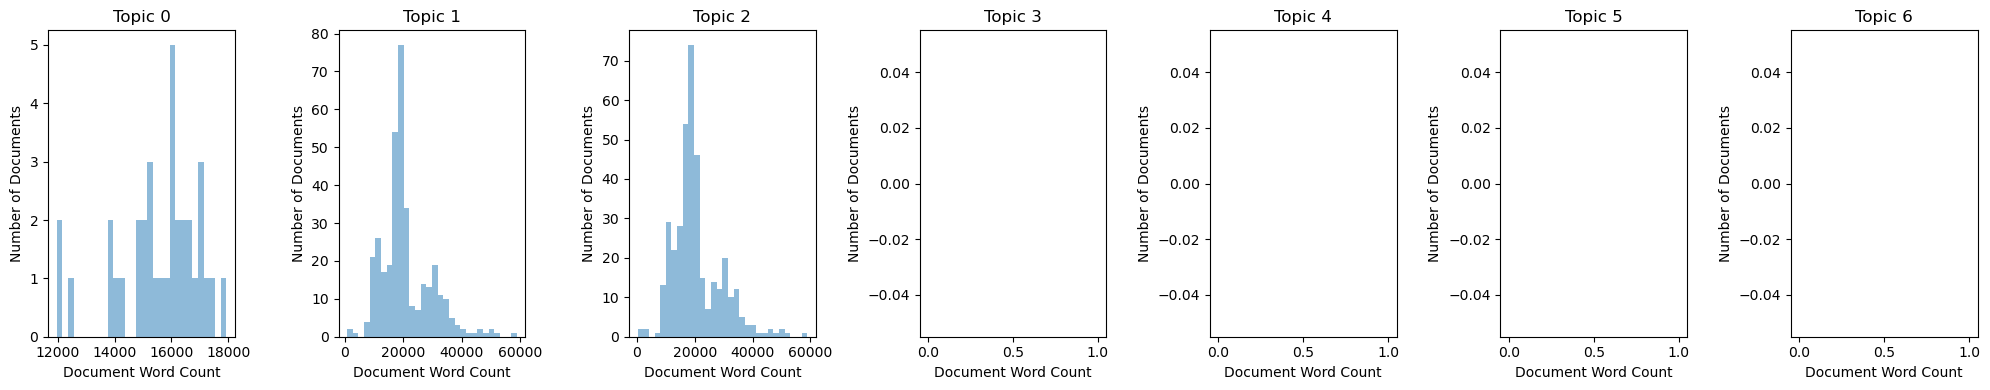

In [19]:
#Ploting document word count against nubmer of documents for LDA model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 4))

for i in range(7):
    word_counts = []

    
    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda_model.get_document_topics(doc)

        # Check if the current topic is the dominant topic for the document
        for topic, prob in doc_topics:
            if topic == i:
                # Calculate the word count of the document and add it to the list
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    axes[i].hist(word_counts, bins=30, alpha=0.5)
    axes[i].set_title(f'Topic {i}')
    axes[i].set_xlabel('Document Word Count')
    axes[i].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

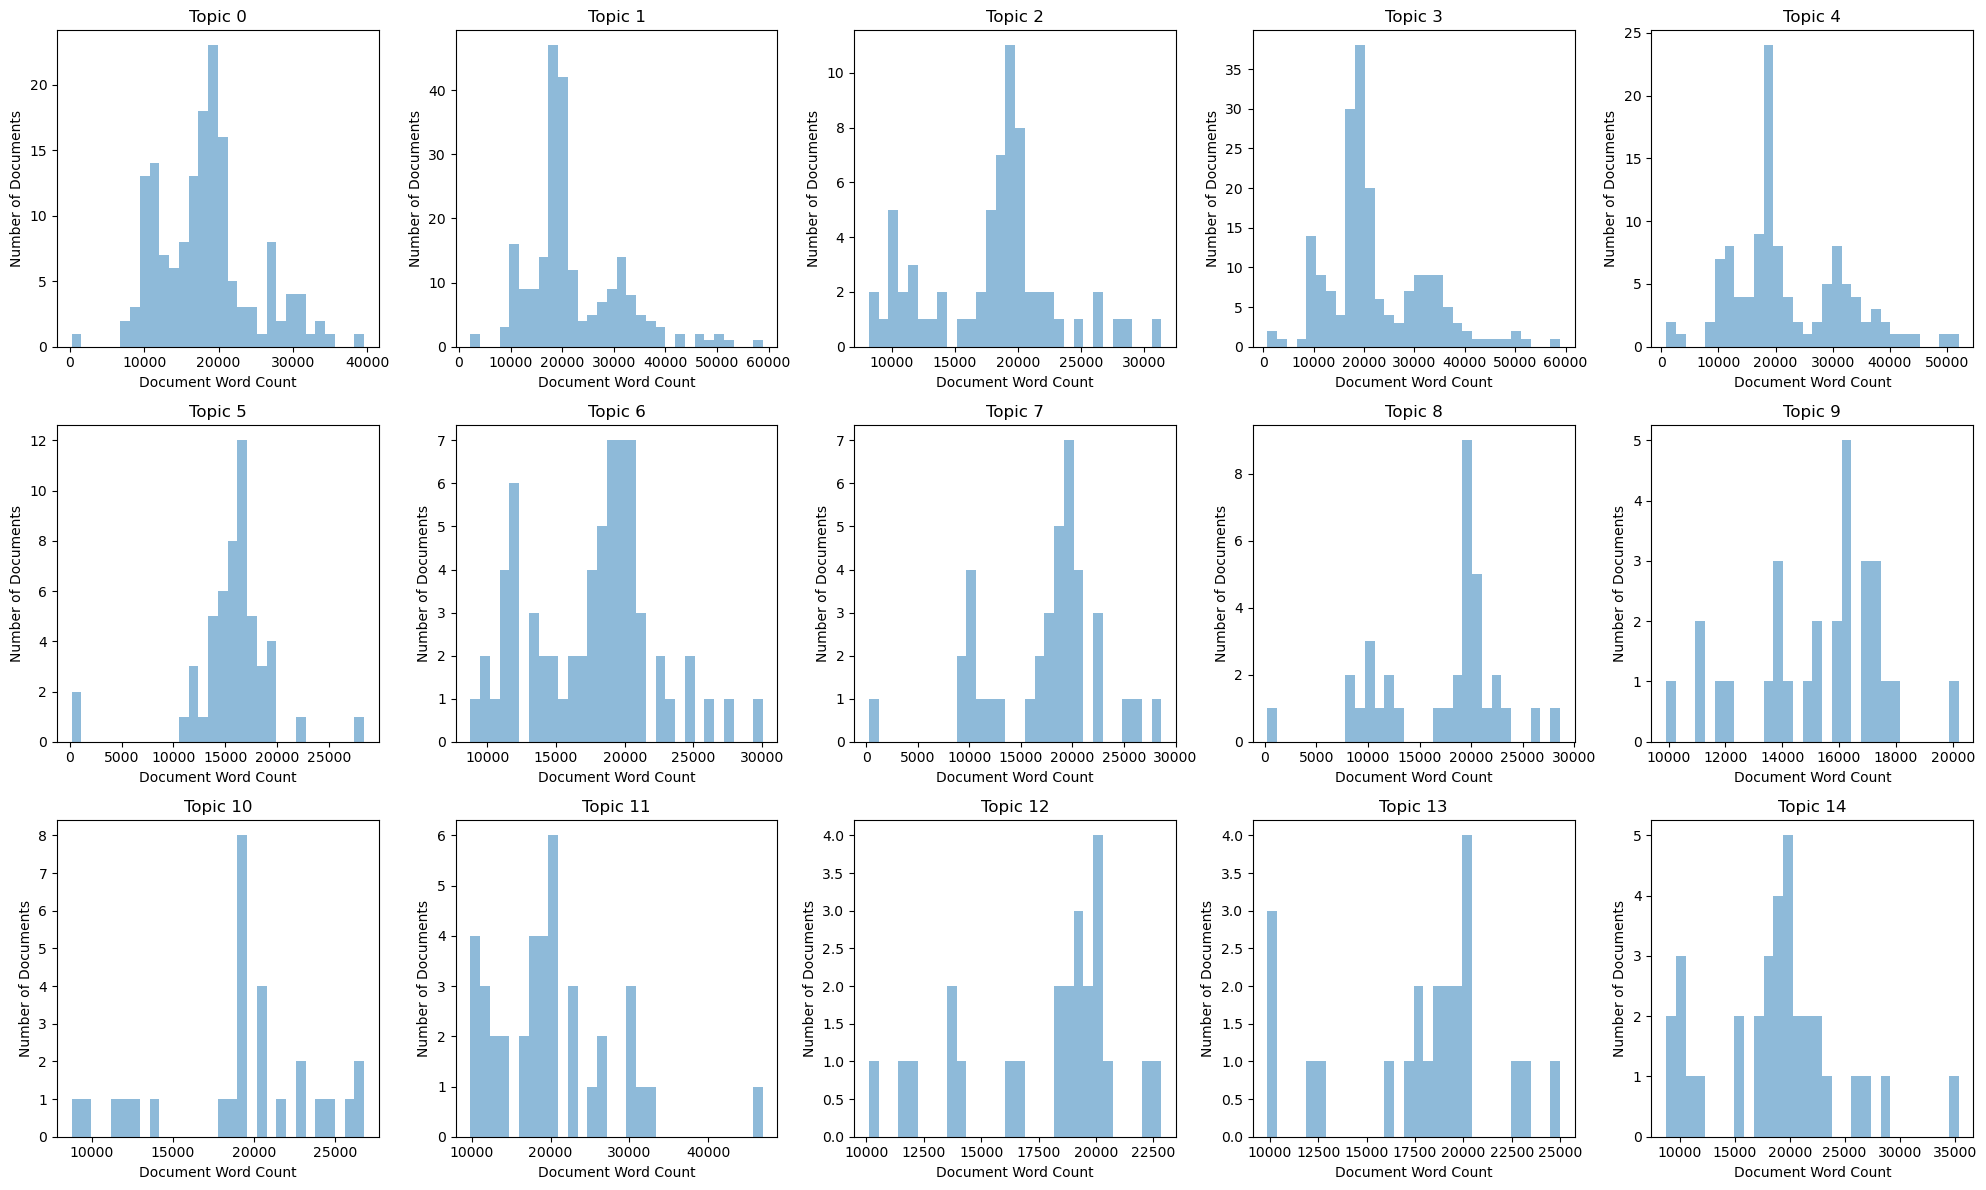

In [20]:
#Ploting document word count against nubmer of documents for HDP model
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))


for i in range(15):
    word_counts = []

    for doc in corpus:
        doc_topics = hdp_model[doc]

        for topic, prob in doc_topics:
            if topic == i:
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    # Determine the position of the subplot in the grid
    row_index = i // 5
    col_index = i % 5

    axes[row_index, col_index].hist(word_counts, bins=30, alpha=0.5)
    axes[row_index, col_index].set_title(f'Topic {i}')
    axes[row_index, col_index].set_xlabel('Document Word Count')
    axes[row_index, col_index].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

In [21]:
#Exploring the relevant terms for each topic of the LDA Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
2     -0.406544+0.000000j -0.014347+0.000000j       1        1  57.828376
1     -0.402103+0.000000j  0.025956+0.000000j       2        1  39.639186
0      0.133617+0.000000j -0.186782+0.000000j       3        1   2.529160
3      0.168758+0.000000j  0.043793+0.000000j       4        1   0.000820
4      0.168758+0.000000j  0.043793+0.000000j       5        1   0.000820
5      0.168758+0.000000j  0.043793+0.000000j       6        1   0.000820
6      0.168758+0.000000j  0.043793+0.000000j       7        1   0.000820, topic_info=                    Term          Freq         Total Category  logprob  \
5222             ontario   7856.000000   7856.000000  Default  30.0000   
1723          commonsdeb  22551.000000  22551.000000  Default  29.0000   
1824            constitu   6041.000000   6041.000000  Default  28.000

In [22]:
#Exploring the relevant terms for each topic of the HDP Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(hdp_model, corpus, dictionary=dictionary)
vis

KeyboardInterrupt: 